# Example 2: Simulating an Electric Vehicle

In this example, we will perform a full simulation of an electirc vehicle based on trip data from the earlier example. It is assumed that the traffic in the last example has been simulated already and that the trip files are atored in a folder named 'simulated_trip_files'.

The vehicle and battery pack simulations are handled by the 'Vehicle' and 'Pack' classes.

In [3]:
from tracksim.tracksim import Vehicle, Pack

In order to perform the simulation, we first need to define the type of vehicle, the type of battery pack, and the type of cells within the pack. We will use already defined models available in the package.

In [42]:
from tracksim.vehicle_models import ChevyVoltTuned
from tracksim.pack_models import ChevyVoltPack
from tracksim.cell_models import Zheng2024Cell

Each model is stored as a dictionary following a format compatible with TRACKSIM. For example, the cell model holds the following information.

In [43]:
print(ChevyVoltTuned, '\n')
print(ChevyVoltPack, '\n')
print(Zheng2024Cell)

{'Model Name': 'Chevy Volt', 'Reference': 'G. L. Plett, Battery Management Systems, Volume 2: Equivalent Circuit Methods. in Artech House Power engineering series. Boston: Artech house, 2016.', 'No. Wheels': 4, 'Brake Drag [N]': 0, 'Drag Coefficient': 0.22, 'Frontal Area [m2]': 1.84, 'Mass [kg]': 1425, 'Payload [kg]': 75, 'Overhead Power [W]': 200, 'Inverter Efficiency': 0.94, 'Fractional Regen Torque Limit': 0.9, 'Gear Ratio': 12, 'Gear Inertia [kg/m2]': 0.05, 'Gear Efficiency': 0.97, 'Wheel Radius [m]': 0.35, 'Wheel Inertia [kg/m2]': 8, 'Rolling Coefficient': 0.0111, 'Max Motor Torque [Nm]': 1420, 'Rated RPM [RPM]': 4000, 'Max RPM [RPM]': 23000, 'Motor Efficiency': 0.95, 'Motor Inertia [kg/m2]': 0.2} 

{'Model Name': 'ChevyVoltPack', 'Reference': 'G. L. Plett, Battery Management Systems, Volume 2: Equivalent Circuit Methods. in Artech House Power engineering series. Boston: Artech house, 2016.', 'Battery Pack Efficiency': 0.96, 'No. Modules': 12, 'No. Cells Series': 8, 'No. Cells Par

If you are curious where these models come from, you can check the reference in the dictionary.

In [44]:
print(ChevyVoltTuned['Reference'])
print(ChevyVoltPack['Reference'])
print(Zheng2024Cell['Reference'])

G. L. Plett, Battery Management Systems, Volume 2: Equivalent Circuit Methods. in Artech House Power engineering series. Boston: Artech house, 2016.
G. L. Plett, Battery Management Systems, Volume 2: Equivalent Circuit Methods. in Artech House Power engineering series. Boston: Artech house, 2016.
Y. Zheng, Y. Che, X. Hu, X. Sui, and R. Teodorescu, “Online Sensorless Temperature Estimation of Lithium-Ion Batteries Through Electro-Thermal Coupling,” IEEE/ASME Transactions on Mechatronics, vol. 29, no. 6, pp. 4156–4167, Dec. 2024, doi: 10.1109/TMECH.2024.3367291.


Setting up the vehicle and the battery pack with these models is straightforward. First, the pack is defined using the pack and cell models and then the vehicle is configured with the vehicle model and the defined pack.

In [45]:
pack = Pack(ChevyVoltPack, Zheng2024Cell)
vehicle = Vehicle(ChevyVoltTuned, pack)

That's it! Now we can simulate the vehicle and the battery pack. The full simulation follows 3 steps:

1. Simulate the battery power demand based on a desired speed profile
2. Define the initial conditions of the battery pack
3. Simulate the battery pack

In [57]:
import pandas as pd
from tracksim.tracksim import exp_average

# Get trip data

trip_file = 'simulated_trip_files/veh0.csv'
trip_data = pd.read_csv(trip_file)

time = trip_data['Time [s]']
time_delta = time[1] - time[0]
speed = exp_average(trip_data['Speed [m/s]'], 0.2) # Low-pass filter to make a more realistic speed profile

# Set initial battery conditions

soc_init = 0.8 # Initial State Of Charge (SOC)

vehicle.simulate_vehicle(time, speed, time_delta)
pack.set_initial_conditions(soc=soc_init)
vehicle.simulate_battery_pack()


The simulation results for the vehicle and the battery pack are stored in their own dictionaries. These can be accessed by:

In [61]:
print(vehicle.simulation_results,'\n')
print(pack.simulation_results)

{'time': array([   0,    1,    2, ..., 1315, 1316, 1317], dtype=int64), 'time_delta': 1, 'speed_desired': array([ 0.        ,  0.46800705,  1.23986383, ..., 15.09638576,
       15.55182008, 15.82488693]), 'acceleration_desired': array([0.        , 0.46800705, 0.77185678, ..., 0.47277374, 0.45543432,
       0.27306685]), 'acceleration_force_desired': array([   0.        ,  926.70170829, 1528.3551832 , ...,  936.14025014,
        901.80642524,  540.70022867]), 'aero_force': array([0.00000000e+00, 0.00000000e+00, 5.43064459e-02, ...,
       5.30219761e+01, 5.65057400e+01, 5.99665472e+01]), 'rolling_grade_force': array([  0.        ,   0.        , 196.09848783, ..., 196.09848783,
       196.09848783, 196.09848783]), 'torque_demand': array([ 0.        , 27.02879983, 50.29814934, ..., 34.57010416,
       33.67031071, 23.23898686]), 'torque_max': array([1420.        , 1420.        , 1420.        , ..., 1186.33978683,
       1149.18716576, 1115.53327368]), 'regen_limit': array([1278.        , 

Now we can plot some simulation results. First, we might be interested in the vehicle speed, acceleration, and the resulting battery power demand.

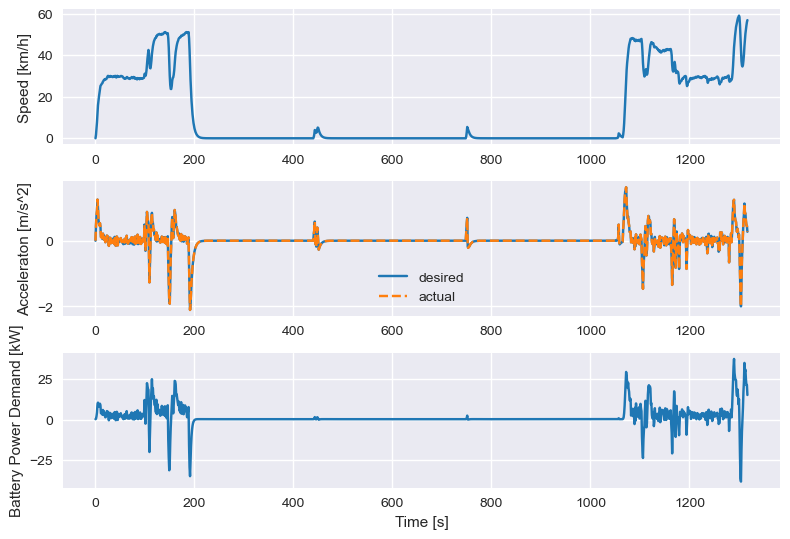

In [60]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-notebook')

fig, ax = plt.subplots(nrows=3)
ax[0].plot(vehicle.simulation_results['speed_desired']*3.6)
ax[0].set_ylabel('Speed [km/h]')
ax[1].plot(vehicle.simulation_results['acceleration_desired'], label='desired')
ax[1].set_ylabel('Acceleraton [m/s^2]')
ax[1].plot(vehicle.simulation_results['acceleration_actual'], linestyle='--', label='actual')
ax[1].legend()
ax[2].plot(vehicle.simulation_results['battery_demand'])
ax[2].set_ylabel('Battery Power Demand [kW]')
ax[2].set_xlabel('Time [s]')

fig.tight_layout()


We can also plot simulation results for the battery pack.

In [63]:
pack.simulation_results['pack'].keys()

dict_keys(['current', 'voltage', 'min_soc', 'max_soc', 'avg_soc', 'min_temp', 'max_temp', 'avg_temp'])

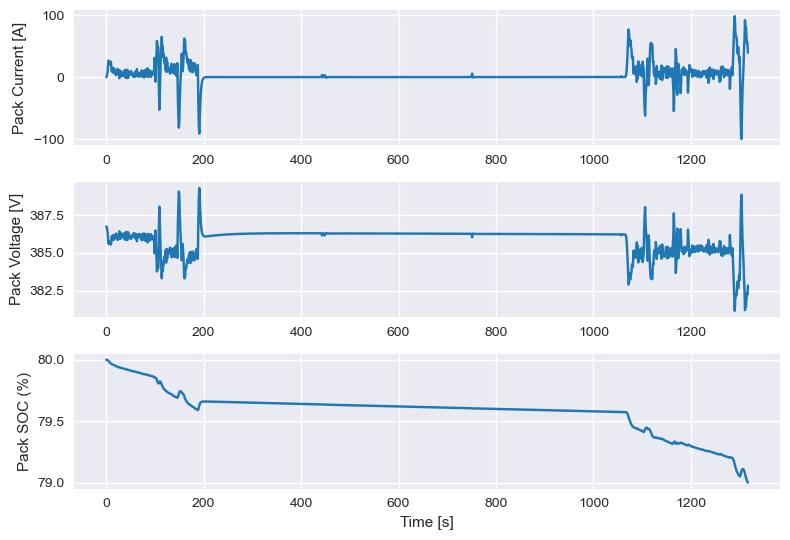

In [70]:
fig, ax = plt.subplots(nrows=3)
ax[0].plot(pack.simulation_results['pack']['current'])
ax[0].set_ylabel('Pack Current [A]')
ax[1].plot(pack.simulation_results['pack']['voltage'])
ax[1].set_ylabel('Pack Voltage [V]')
ax[2].plot(pack.simulation_results['pack']['avg_soc']*100)
ax[2].set_ylabel('Pack SOC (%)')
ax[2].set_xlabel('Time [s]')

fig.tight_layout()

We can also extract the current, voltage, and soc for each cell in the battery pack.

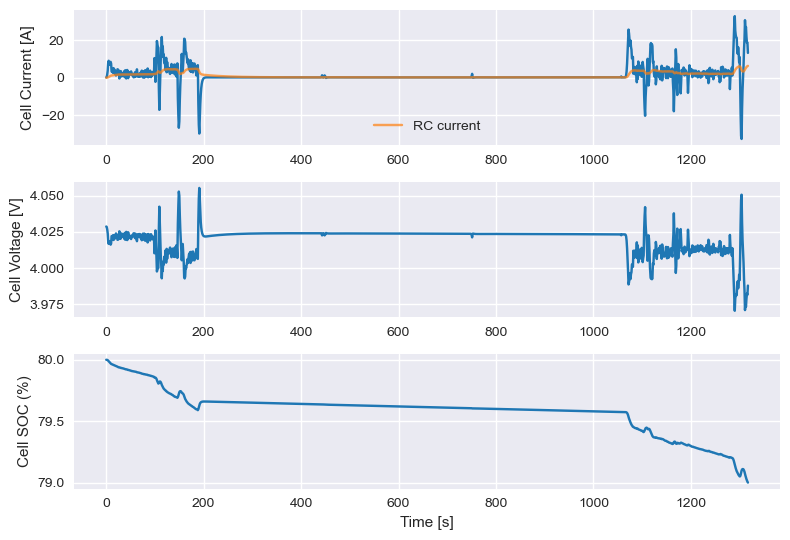

In [71]:
cell_i, cell_j = (0,0) # Cell index

fig, ax = plt.subplots(nrows=3)
ax[0].plot(pack.simulation_results[f'cell_{cell_i}-{cell_j}']['current'])
ax[0].plot(pack.simulation_results[f'cell_{cell_i}-{cell_j}']['current_rc1'], alpha=0.7, label='RC current')
ax[0].legend()
ax[0].set_ylabel('Cell Current [A]')
ax[1].plot(pack.simulation_results[f'cell_{cell_i}-{cell_j}']['voltage'])
ax[1].set_ylabel('Cell Voltage [V]')
ax[2].plot(pack.simulation_results[f'cell_{cell_i}-{cell_j}']['soc']*100)
ax[2].set_ylabel('Cell SOC (%)')
ax[2].set_xlabel('Time [s]')

fig.tight_layout()
